# 图解transformer

内容组织：
- 图解transformer
    - Transformer宏观结构
    - Transformer结构细节
      - 输入处理
        - 词向量
        - 位置向量
      - 编码器encoder
        - Self-Attention层
        - 多头注意力机制
        - Attention代码实例
        - 残差连接
      - 解码器
      - 线性层和softmax
      - 损失函数
    - 附加资料
    - 致谢

在学习完[图解attention](./2.1图解attention.ipynb)后，我们知晓了attention为循环神经网络带来的优点。那么有没有**一种神经网络结构**直接基于attention构造，并且不再依赖RNN、LSTM或者CNN网络结构了呢？答案便是：Transformer。因此，我们将在本小节对Transformer所涉及的细节进行深入探讨。

Transformer模型在2017年被google提出，直接基于Self-Attention结构，取代了之前NLP任务中常用的RNN神经网络结构。
与RNN这类神经网络结构相比，Transformer一个巨大的优点是：模型在处理序列输入时，**可以对整个序列输入进行并行计算，不需要按照时间步循环递归处理输入序列**。

下图先便是Transformer整体结构图，与篇章2.1中介绍的seq2seq模型类似，Transformer模型结构中的左半部分为编码器（encoder），右半部分为解码器（decoder），下面我们来一步步拆解 Transformer。

![transformer](./pictures/2-transformer.png)
图：transformer模型结构


注释和引用说明：本文将通过总-分的方式对Transformer进行拆解和讲解，希望有助于帮助初学者理解Transformer模型结构。本文主要参考[illustrated-transformer](http://jalammar.github.io/illustrated-transformer)。

## Transformer宏观结构

注意：本小节为讲解方式为：总-分，先整体，再局部。

Transformer最开始提出来解决机器翻译任务，因此可以看作是seq2seq模型的一种。本小节先抛开Transformer模型中结构具体细节，先从seq2seq的角度对Transformer进行宏观结构的学习。以机器翻译任务为例，先将Transformer这种特殊的seqseq模型看作一个黑盒，黑盒的输入是法语文本序列，输出是英语文本序列（对比2.1章节的seq2seq框架知识我们可以发现，Transformer宏观结构属于seq2seq范畴，只是将之前seq2seq中的编码器和解码器，从RNN模型替换成了Transformer模型）。

![input-output](./pictures/2-input-output.png)
图：Transformer黑盒输入和输出

将上图中的中间部分“THE TRANSFORMER”拆开成seq2seq标准结构，得到下图：左边是编码部分encoders，右边是解码器部分decoders。
![encoder-decoder](./pictures/2-encoder-decoder.png)
图：encoder-decoder

下面，再将上图中的编码器和解码器细节绘出，得到下图。我们可以看到，编码部分（encoders）由多层编码器(Encoder)组成（Transformer论文中使用的是6层编码器，这里的层数6并不是固定的，你也可以根据实验效果来修改层数）。同理，解码部分（decoders）也是由多层的解码器(Decoder)组成（论文里也使用了6层解码器）。每层编码器网络结构是一样的，每层解码器网络结构也是一样的。不同层编码器和解码器网络结构不共享参数。
![翻译例子](./pictures/2-2-encoder-detail.png)

图：6层编码和6层解码器

接下来，我们看一下单层encoder，单层encoder主要由以下两部分组成，如下图所示
- Self-Attention Layer
- Feed Forward Neural Network（前馈神经网络，缩写为 FFNN）

编码器的输入文本序列$w_1, w_2,...,w_n$最开始需要经过embedding转换，得到每个单词的向量表示$x_1, x_2,...,x_n$，其中$x_i \in \mathbb{R}^{d}$是维度为$d$的向量，然后所有向量经过一个Self-Attention神经网络层进行变换和信息交互得到$h_1, h_2,...h_n$，其中$h_i \in \mathbb{R}^{d}$是维度为$d$的向量。self-attention层处理一个词向量的时候，不仅会使用这个词本身的信息，也会使用句子中其他词的信息（你可以类比为：当我们翻译一个词的时候，不仅会只关注当前的词，也会关注这个词的上下文的其他词的信息）。Self-Attention层的输出会经过前馈神经网络得到新的$x_1, x_2,..,x_n$，依旧是$n$个维度为$d$的向量。这些向量将被送入下一层encoder，继续相同的操作。

![encoder](./pictures/2-encoder.png)

图：单层encoder


与编码器对应，如下图，解码器在编码器的self-attention和FFNN中间插入了一个Encoder-Decoder Attention层，这个层帮助解码器聚焦于输入序列最相关的部分（类似于seq2seq模型中的 Attention）。

![decoder](./pictures/2-decoder.webp)

图：单层decoder

总结一下，我们基本了解了Transformer由编码部分和解码部分组成，而编码部分和解码部分又由多个网络结构相同的编码层和解码层组成。每个编码层由self-attention和FFNN组成，每个解码层由self-attention、FFN和encoder-decoder attention组成。

以上便是Transformer的宏观结构啦，下面我们开始看宏观结构中的模型细节。

## Transformer结构细节

了解了Transformer的宏观结构之后。下面，让我们来看看Transformer如何将输入文本序列转换为向量表示，又如何逐层处理这些向量表示得到最终的输出。

因此本节主要内容依次包含：
- 输入处理
  - 词向量
  - 位置向量
- 编码器
- 解码器


### 输入处理

#### 词向量
和常见的NLP 任务一样，我们首先会使用词嵌入算法（embedding algorithm），将输入文本序列的每个词转换为一个词向量。实际应用中的向量一般是 256 或者 512 维。但为了简化起见，我们这里使用4维的词向量来进行讲解。

如下图所示，假设我们的输入文本是序列包含了3个词，那么每个词可以通过词嵌入算法得到一个4维向量，于是整个输入被转化成为一个向量序列。在实际应用中，我们通常会同时给模型输入多个句子，如果每个句子的长度不一样，我们会选择一个合适的长度，作为输入文本序列的最大长度：如果一个句子达不到这个长度，那么就填充先填充一个特殊的“padding”词；如果句子超出这个长度，则做截断。最大序列长度是一个超参数，通常希望越大越好，但是更长的序列往往会占用更大的训练显存/内存，因此需要在模型训练时候视情况进行决定。

![ 个词向量](./pictures/2-x.png)
图：3个词和对应的词向量

输入序列每个单词被转换成词向量表示还将加上位置向量来得到该词的最终向量表示。

#### 位置向量

如下图所示，Transformer模型对每个输入的词向量都加上了一个位置向量。这些向量有助于确定每个单词的位置特征，或者句子中不同单词之间的距离特征。词向量加上位置向量背后的直觉是：将这些表示位置的向量添加到词向量中，得到的新向量，可以为模型提供更多有意义的信息，比如词的位置，词之间的距离等。

![位置编码](./pictures/2-position.png)
图：位置编码向量

依旧假设词向量和位置向量的维度是4，我们在下图中展示一种可能的位置向量+词向量：

![位置编码](./pictures/2-position2.png)
图：位置编码向量

那么带有位置编码信息的向量到底遵循什么模式？原始论文中给出的设计表达式为：
$$                                                                    
    PE_{(pos,2i)} = sin(pos / 10000^{2i/d_{\text{model}}}) \\                                                                       PE_{(pos,2i+1)} = cos(pos / 10000^{2i/d_{\text{model}}})$$
上面表达式中的$pos$代表词的位置，$d_{model}$代表位置向量的维度，$i \in [0, d_{model})$代表位置$d_{model}$维位置向量第$i$维。于是根据上述公式，我们可以得到第$pos$位置的$d_{model}$维位置向量。在下图中，我们画出了一种位置向量在第4、5、6、7维度、不同位置的的数值大小。横坐标表示位置下标，纵坐标表示数值大小。

![位置编码图示](./pictures/2-2-pos-embedding.png)
图：位置编码在0-100位置，在4、5、6、7维的数值图示

当然，上述公式不是唯一生成位置编码向量的方法。但这种方法的优点是：可以扩展到未知的序列长度。例如：当我们的模型需要翻译一个句子，而这个句子的长度大于训练集中所有句子的长度，这时，这种位置编码的方法也可以生成一样长的位置编码向量。

**注：这里有些没有理解。**

#### <h3 id='self-attention'> Self-Attention层 </h3>

下面来分析一下上图中Self-Attention层的具体机制。

##### <h3 id='self-attention-abstract'> Self-Attention概览 </h3>

假设我们想要翻译的句子是：
```
The animal didn't cross the street because it was too tired
```
这个句子中的 *it* 是一个指代词，那么 *it* 指的是什么呢？它是指 *animal* 还是*street*？这个问题对人来说，是很简单的，但是对模型来说并不是那么容易。但是，如果模型引入了*Self Attention*机制之后，便能够让模型把it和animal关联起来了。同样的，当模型处理句子中其他词时，*Self Attentio*n机制也可以使得模型不仅仅关注当前位置的词，还会关注句子中其他位置的相关的词，进而可以更好地理解当前位置的词。

与2.1章节中提到的RNN对比一下：RNN 在处理序列中的一个词时，会考虑句子前面的词传过来的*hidden state*，而*hidden state*就包含了前面的词的信息；而*Self Attention*机制值得是，当前词会直接关注到自己句子中前后相关的所有词语，如下图 *it*的例子：

![一个词和其他词的attention](./pictures/2-attention-word.png)

图：一个词和其他词的attention

上图所示的*it*是一个真实的例子，是当Transformer在第5层编码器编码“it”时的状态，可视化之后显示*it*有一部分注意力集中在了“The animal”上，并且把这两个词的信息融合到了"it"中。

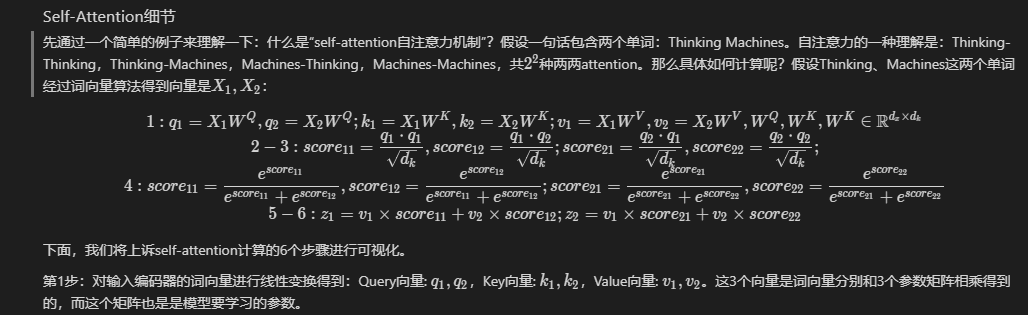

####  上图中公式有问题吗？  2-3步中，是 q1 * k1 这样的？

下面，我们将上诉self-attention计算的6个步骤进行可视化。

第1步：对输入编码器的词向量进行线性变换得到：Query向量: $q_1, q_2$，Key向量: $k_1, k_2$，Value向量: $v_1, v_2$。这3个向量是词向量分别和3个参数矩阵相乘得到的，而这个矩阵也是是模型要学习的参数。

![Q,K,V](./pictures/2-qkv.png)图：计算Query向量：$q_1, q_2$，Key向量: $k_1, k_2$，Value向量: $v_1, v_2$。

Query 向量，Key 向量，Value 向量是什么含义呢？

其实它们就是 3 个向量，给它们加上一个名称，可以让我们更好地理解 Self-Attention 的计算过程和逻辑。attention计算的逻辑常常可以描述为：query和key计算相关或者叫attention得分，然后根据attention得分对value进行加权求和。

第2步：计算Attention Score（注意力分数）。假设我们现在计算第一个词*Thinking* 的Attention Score（注意力分数），需要根据*Thinking* 对应的词向量，对句子中的其他词向量都计算一个分数。这些分数决定了我们在编码*Thinking*这个词时，需要对句子中其他位置的词向量的权重。

Attention score是根据"*Thinking*" 对应的 Query 向量和其他位置的每个词的 Key 向量进行点积得到的。Thinking的第一个Attention Score就是$q_1$和$k_1$的内积，第二个分数就是$q_1$和$k_2$的点积。这个计算过程在下图中进行了展示，下图里的具体得分数据是为了表达方便而自定义的。

![Thinking计算](./pictures/2-think.png)
图：Thinking的Attention Score计算


第3步：把每个分数除以 $\sqrt{d_k}$，$d_{k}$是Key向量的维度。你也可以除以其他数，除以一个数是为了在反向传播时，求梯度时更加稳定。

第4步：接着把这些分数经过一个Softmax函数，Softmax可以将分数归一化，这样使得分数都是正数并且加起来等于1， 如下图所示。
这些分数决定了Thinking词向量，对其他所有位置的词向量分别有多少的注意力。

![Thinking计算](./pictures/2-think2.png)
图：Thinking的Attention Score计算

第5步：得到每个词向量的分数后，将分数分别与对应的Value向量相乘。**这种做法背后的直觉理解就是：对于分数高的位置，相乘后的值就越大，我们把更多的注意力放到了它们身上；对于分数低的位置，相乘后的值就越小，这些位置的词可能是相关性不大的**。

第6步：把第5步得到的Value向量相加，就得到了Self Attention在当前位置（这里的例子是第1个位置）对应的输出。

最后，在下图展示了 对第一个位置词向量计算Self Attention 的全过程。最终得到的当前位置（这里的例子是第一个位置）词向量会继续输入到前馈神经网络。注意：上面的6个步骤每次只能计算一个位置的输出向量，在实际的代码实现中，Self Attention的计算过程是使用矩阵快速计算的，一次就得到所有位置的输出向量。

![Think计算](./pictures/2-sum.png)
图：Thinking经过attention之后的向量表示$z_1$

##### Self-Attention矩阵计算

将self-attention计算6个步骤中的向量放一起，比如$X=[x_1;x_2]$，便可以进行矩阵计算啦。下面，依旧按步骤展示self-attention的矩阵计算方法。
$$X = [X_1;X_2] \\
Q = X W^Q, K = X W^K, V=X W^V \\
Z = softmax(\frac{QK^T}{\sqrt{d_k}}) V$$

第1步：计算 Query，Key，Value 的矩阵。首先，我们把所有词向量放到一个矩阵X中，然后分别和3个权重矩阵$W^Q, W^K W^V$ 相乘，得到 Q，K，V 矩阵。矩阵X中的每一行，表示句子中的每一个词的词向量。Q，K，V 矩阵中的每一行表示 Query向量，Key向量，Value 向量，向量维度是$d_k$。

![](./pictures/2-qkv-multi.png)图：QKV矩阵乘法

第2步：由于我们使用了矩阵来计算，我们可以把上面的第 2 步到第 6 步压缩为一步，直接得到 Self Attention 的输出。

![输出](./pictures/2-attention-output.webp)
图：得到输出$Z$

#### 多头注意力机制

Transformer 的论文通过增加多头注意力机制（一组注意力称为一个 attention head），进一步完善了Self-Attention。这种机制从如下两个方面增强了attention层的能力：

- 它扩展了模型关注不同位置的能力。在上面的例子中，第一个位置的输出$z_1$包含了句子中其他每个位置的很小一部分信息，但$z_1$仅仅是单个向量，所以可能仅由第1个位置的信息主导了。而当我们翻译句子：`The animal didn’t cross the street because it was too tired`时，我们不仅希望模型关注到"it"本身，还希望模型关注到"The"和“animal”，甚至关注到"tired"。这时，多头注意力机制会有帮助。
- 多头注意力机制赋予attention层多个“子表示空间”。下面我们会看到，多头注意力机制会有多组$W^Q, W^K W^V$ 的权重矩阵（在 Transformer 的论文中，使用了 8 组注意力),，因此可以将$X$变换到更多种子空间进行表示。接下来我们也使用8组注意力头（attention heads））。每一组注意力的权重矩阵都是随机初始化的，但经过训练之后，每一组注意力的权重$W^Q, W^K W^V$ 可以把输入的向量映射到一个对应的”子表示空间“。

![多头注意力机制](./pictures/2-multi-head.png)
图：多头注意力机制


在多头注意力机制中，我们为每组注意力设定单独的 WQ, WK, WV 参数矩阵。将输入X和每组注意力的WQ, WK, WV 相乘，得到8组 Q, K, V 矩阵。

接着，我们把每组 K, Q, V 计算得到每组的 Z 矩阵，就得到8个Z矩阵。

![8 个 Z 矩阵](./pictures/2-8z.webp)
图：8 个 Z 矩阵

由于前馈神经网络层接收的是 1 个矩阵（其中每行的向量表示一个词），而不是 8 个矩阵，所以我们直接把8个子矩阵拼接起来得到一个大的矩阵，然后和另一个权重矩阵$W^O$相乘做一次变换，映射到前馈神经网络层所需要的维度。

![整合矩阵](./pictures/2-to1.webp)
图：拼接8个子矩阵并进行映射变换

总结一下就是：
1. 把8个矩阵 {Z0,Z1...,Z7} 拼接起来
2. 把拼接后的矩阵和WO权重矩阵相乘
3. 得到最终的矩阵Z，这个矩阵包含了所有 attention heads（注意力头） 的信息。这个矩阵会输入到FFNN (Feed Forward Neural Network)层。

以上就是多头注意力的全部内容。最后将所有内容放到一张图中：

![放在一起](./pictures/2-put-together.webp)
图：多头注意力机制的矩阵运算

学习网多头注意力机制，让我们再来看下当我们前面提到的it例子，不同的attention heads （注意力头）对应的“it”attention了哪些内容。下图中的绿色和橙色线条分别表示2组不同的attentin heads：

![`it`的attention](./pictures/2-it-attention.webp)
图：`it`的attention

当我们编码单词"it"时，其中一个 attention head （橙色注意力头）最关注的是"the animal"，另外一个绿色 attention head 关注的是"tired"。因此在某种意义上，"it"在模型中的表示，融合了"animal"和"tire"的部分表达。

#### Attention代码实例
下面的代码实现中，张量的第1维是 batch size，第 2 维是句子长度。代码中进行了详细注释和说明。

In [6]:
import torch
from torch import nn

In [7]:
class MultiheadAttention(nn.Model):
    # n_heads:多头注意力的数量
    # hid_dim:每个词输出的向量维度
    def __init__(self,hid_dim,n_heads,dropout):
        super(MultiheadAttention, self).__init__()
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        
        #强制 hid_dim 必须整除 h 
        assert hid_dim % n_heads == 0
        # 定义 w_q 矩阵
        self.w_q = nn.Liner(hid_dim, hid_dim)
        # 定义 w_k 矩阵
        self.w_k = nn.Liner(hid_dim, hid_dim)
        # 定义 w_v 矩阵
        self.w_v = nn.Liner(hid_dim, hid_dim)
        self.fc = nn.Liner(hid_dim,hid_dim)
        self.do = nn.Dropout(dropout)
        # 缩放
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim//n_heads]))

    def forward(self, query, key, value, mask=None):
        # 注意 Q，K，V的在句子长度这一个维度的数值可以一样，可以不一样。
        # K: [64,10,300], 假设batch_size 为 64，有 10 个词，每个词的 Query 向量是 300 维
        # V: [64,10,300], 假设batch_size 为 64，有 10 个词，每个词的 Query 向量是 300 维
        # Q: [64,12,300], 假设batch_size 为 64，有 12 个词，每个词的 Query 向量是 300 维
        bsz = query.shape[0]
        Q = self.w_q(query)
        K = self.w_k(key)
        V = self.w_v(value)
        # 这里把 K Q V 矩阵拆分为多组注意力
        # 最后一维就是是用 self.hid_dim // self.n_heads 来得到的，表示每组注意力的向量长度, 每个 head 的向量长度是：300/6=50
        # 64 表示 batch size，6 表示有 6组注意力，10 表示有 10 词，50 表示每组注意力的词的向量长度
        # K: [64,10,300] 拆分多组注意力 -> [64,10,6,50] 转置得到 -> [64,6,10,50]
        # V: [64,10,300] 拆分多组注意力 -> [64,10,6,50] 转置得到 -> [64,6,10,50]
        # Q: [64,12,300] 拆分多组注意力 -> [64,12,6,50] 转置得到 -> [64,6,12,50]
        # 转置是为了把注意力的数量 6 放到前面，把 10 和 50 放到后面，方便下面计算
        Q = Q.view(bsz, -1, self.n_heads, self.hid_dim //
                   self.n_heads).permute(0, 2, 1, 3)
        K = K.view(bsz, -1, self.n_heads, self.hid_dim //
                   self.n_heads).permute(0, 2, 1, 3)
        V = V.view(bsz, -1, self.n_heads, self.hid_dim //
                   self.n_heads).permute(0, 2, 1, 3)

        # 第 1 步：Q 乘以 K的转置，除以scale
        # [64,6,12,50] * [64,6,50,10] = [64,6,12,10]
        # attention：[64,6,12,10]
        attention = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale

        # 如果 mask 不为空，那么就把 mask 为 0 的位置的 attention 分数设置为 -1e10，这里用“0”来指示哪些位置的词向量不能被attention到，比如padding位置，当然也可以用“1”或者其他数字来指示，主要设计下面2行代码的改动。
        if mask is not None:
            attention = attention.masked_fill(mask == 0, -1e10)

        # 第 2 步：计算上一步结果的 softmax，再经过 dropout，得到 attention。
        # 注意，这里是对最后一维做 softmax，也就是在输入序列的维度做 softmax
        # attention: [64,6,12,10]
        attention = self.do(torch.softmax(attention, dim=-1))

        # 第三步，attention结果与V相乘，得到多头注意力的结果
        # [64,6,12,10] * [64,6,10,50] = [64,6,12,50]
        # x: [64,6,12,50]
        x = torch.matmul(attention, V)

        # 因为 query 有 12 个词，所以把 12 放到前面，把 50 和 6 放到后面，方便下面拼接多组的结果
        # x: [64,6,12,50] 转置-> [64,12,6,50]
        x = x.permute(0, 2, 1, 3).contiguous()
        # 这里的矩阵转换就是：把多组注意力的结果拼接起来
        # 最终结果就是 [64,12,300]
        # x: [64,12,6,50] -> [64,12,300]
        x = x.view(bsz, -1, self.n_heads * (self.hid_dim // self.n_heads))
        x = self.fc(x)
        return x


# batch_size 为 64，有 12 个词，每个词的 Query 向量是 300 维
query = torch.rand(64, 12, 300)
# batch_size 为 64，有 12 个词，每个词的 Key 向量是 300 维
key = torch.rand(64, 10, 300)
# batch_size 为 64，有 10 个词，每个词的 Value 向量是 300 维
value = torch.rand(64, 10, 300)
attention = MultiheadAttention(hid_dim=300, n_heads=6, dropout=0.1)
output = attention(query, key, value)
## output: torch.Size([64, 12, 300])
print(output.shape)

#### 残差连接

到目前为止，我们计算得到了self-attention的输出向量。而单层encoder里后续还有两个重要的操作：残差链接、标准化。

编码器的每个子层（Self Attention 层和 FFNN）都有一个残差连接和层标准化（layer-normalization），如下图所示。

![残差连接](./pictures/2-resnet.png)
图：残差连接

将 Self-Attention 层的层标准化（layer-normalization）和涉及的向量计算细节都进行可视化，如下所示：

![标准化](./pictures/2-lyn.png)
图：标准化细节

编码器和和解码器的子层里面都有层标准化（layer-normalization）。假设一个 Transformer 是由 2 层编码器和两层解码器组成的，将全部内部细节展示起来如下图所示。


![2层示意图](./pictures/2-2layer.png)
图：2层Transformer示意图

## 解码器

现在我们已经介绍了编码器中的大部分概念，我们也基本知道了编码器的原理。现在让我们来看下， 编码器和解码器是如何协同工作的。

编码器一般有多层，第一个编码器的输入是一个序列文本，最后一个编码器输出是一组序列向量，这组序列向量会作为解码器的K、V输入，其中K=V=解码器输出的序列向量表示。这些注意力向量将会输入到每个解码器的Encoder-Decoder Attention层，这有助于解码器把注意力集中到输入序列的合适位置，如下图所示。

![](./pictures/transformer_decoding_1.gif)

解码（decoding ）阶段的每一个时间步都输出一个翻译后的单词（这里的例子是英语翻译），**解码器当前时间步的输出又重新作为输入Q和编码器的输出K、V共同作为下一个时间步解码器的输入**。然后重复这个过程，直到输出一个结束符。如下图所示：

![decoder动态图](./pictures/2-decoder.gif)
动态图：decoder动态图

解码器中的 Self Attention 层，和编码器中的 Self Attention 层的区别：
1. 在解码器里，Self Attention 层只允许关注到输出序列中早于当前位置之前的单词。具体做法是：在 Self Attention 分数经过 Softmax 层之前，屏蔽当前位置之后的那些位置（将attention score设置成-inf）。
2. 解码器 Attention层是使用前一层的输出来构造Query 矩阵，而Key矩阵和 Value矩阵来自于编码器最终的输出。

#### 注：这里的区别，我有点没有理解。

## 线性层和softmax

Decoder 最终的输出是一个向量，其中每个元素是浮点数。我们怎么把这个向量转换为单词呢？这是线性层和softmax完成的。

线性层就是一个普通的全连接神经网络，可以把解码器输出的向量，映射到一个更大的向量，这个向量称为 logits 向量：假设我们的模型有 10000 个英语单词（模型的输出词汇表），此 logits 向量便会有 10000 个数字，每个数表示一个单词的分数。

然后，Softmax 层会把这些分数转换为概率（把所有的分数转换为正数，并且加起来等于 1）。然后选择最高概率的那个数字对应的词，就是这个时间步的输出单词。

![线性层](./pictures/2-linear.png)
图：线性层

## 损失函数

Transformer训练的时候，需要将解码器的输出和label一同送入损失函数，以获得loss，最终模型根据loss进行方向传播。这一小节，我们用一个简单的例子来说明训练过程的loss计算：把“merci”翻译为“thanks”。

我们希望模型解码器最终输出的概率分布，会指向单词 ”thanks“（在“thanks”这个词的概率最高）。但是，一开始模型还没训练好，它输出的概率分布可能和我们希望的概率分布相差甚远，如下图所示，正确的概率分布应该是“thanks”单词的概率最大。但是，由于模型的参数都是随机初始化的，所示一开始模型预测所有词的概率几乎都是随机的。

![概率分布](./pictures/2-loss.webp)
图：概率分布

只要Transformer解码器预测了组概率，我们就可以把这组概率和正确的输出概率做对比，然后使用反向传播来调整模型的权重，使得输出的概率分布更加接近整数输出。

那我们要怎么比较两个概率分布呢？：我们可以简单的用两组概率向量的的空间距离作为loss（向量相剑，然后求平方和，再开方），当然也可以使用交叉熵(cross-entropy)]和KL 散度(Kullback–Leibler divergence)。读者可以进一步检索阅读相关知识，损失函数的知识不在本小节展开。

由于上面仅有一个单词的例子太简单了，我们可以再看一个复杂一点的句子。句子输入是：“je suis étudiant” ，输出是：“i am a student”。这意味着，我们的transformer模型解码器要多次输出概率分布向量：

- 每次输出的概率分布都是一个向量，长度是 vocab_size（前面约定最大vocab size，也就是向量长度是 6，但实际中的vocab size更可能是 30000 或者 50000）
- 第1次输出的概率分布中，最高概率对应的单词是 “i”
- 第2次输出的概率分布中，最高概率对应的单词是 “am”
- 以此类推，直到第 5 个概率分布中，最高概率对应的单词是 “\<eos>”，表示没有下一个单词了

于是我们目标的概率分布长下面这个样子：

![概率分布](./pictures/2-target.png)
图：目标概率分布

我们用例子中的句子训练模型，希望产生图中所示的概率分布
我们的模型在一个足够大的数据集上，经过足够长时间的训练后，希望输出的概率分布如下图所示：

![训练后概率分布](./pictures/2-trained.webp)
图：模型训练后输出的多个概率分布

我们希望模型经过训练之后可以输出的概率分布也就对应了正确的翻译。当然，如果你要翻译的句子是训练集中的一部分，那输出的结果并不能说明什么。我们希望模型在没见过的句子上也能够准确翻译。

额外提一下greedy decoding和beam search的概念：
- Greedy decoding：由于模型每个时间步只产生一个输出，我们这样看待：模型是从概率分布中选择概率最大的词，并且丢弃其他词。这种方法叫做贪婪解码（greedy decoding）。
- Beam search：每个时间步保留k个最高概率的输出词，然后在下一个时间步，根据上一个时间步保留的k个词来确定当前应该保留哪k个词。假设k=2，第一个位置概率最高的两个输出的词是”I“和”a“，这两个词都保留，然后根据第一个词计算第2个位置的词的概率分布，再取出第2个位置上2个概率最高的词。对于第3个位置和第4个位置，我们也重复这个过程。这种方法称为集束搜索(beam search)。

## 附加资料

我希望上面讲的内容，可以帮助你理解 Transformer 中的主要概念。如果你想更深一步地理解，我建议你可以参考下面这些：

- 阅读 Transformer 的论文：
《Attention Is All You Need》
链接地址：https://arxiv.org/abs/1706.03762
- 阅读Transformer 的博客文章：
《Transformer: A Novel Neural Network Architecture for Language Understanding》
链接地址：https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html
阅读《Tensor2Tensor announcement》
- 链接地址：https://ai.googleblog.com/2017/06/accelerating-deep-learning-research.html
- 观看视频 【Łukasz Kaiser’s talk】来理解模型和其中的细节
链接地址：https://www.youtube.com/watch?v=rBCqOTEfxvg
运行这份代码：【Jupyter Notebook provided as part of the Tensor2Tensor repo】
- 链接地址：https://colab.research.google.com/github/tensorflow/tensor2tensor/blob/master/tensor2tensor/notebooks/hello_t2t.ipynb。
- 查看这个项目：【Tensor2Tensor repo】
链接地址：https://github.com/tensorflow/tensor2tensor
